In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

**Train Data set**

In [2]:
#train Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:03<00:00, 44220483.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


**Test Dataset**

In [3]:
#Test Data set
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True,
                                        transform=transforms.ToTensor())

Files already downloaded and verified


In [4]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [13]:
image_tensor, label = train_dataset[0]
print(image_tensor.shape)

torch.Size([3, 32, 32])


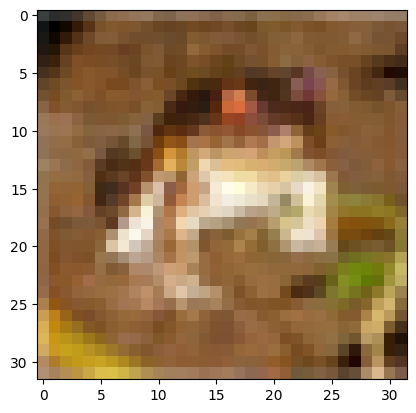

label:  6


In [4]:
# visualizing the image
import matplotlib.pyplot as plt
image, label = train_dataset[0]
plt.imshow(image.permute(1, 2, 0))
plt.show()
print('label: ', label)

**Train and Validation Loader**

In [5]:
# creating validation set

from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid

train_ds, val_ds = random_split(train_dataset, [40000, 10000])

In [6]:
print(len(train_ds))
print(len(val_ds))

40000
10000


In [7]:
batch_size = 128
train_Loader = DataLoader(train_ds, batch_size, shuffle =True)
val_Loader  = DataLoader(val_ds, batch_size)


Image Sahpe: torch.Size([128, 3, 32, 32])


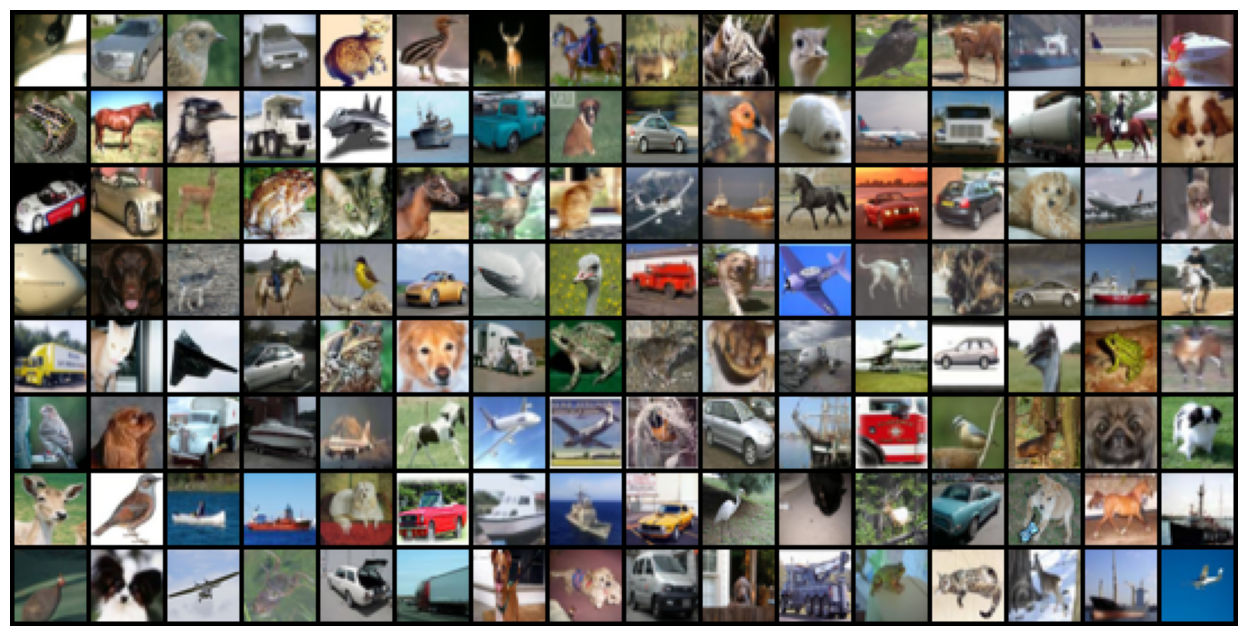

In [8]:
#griding of batch

for images, labels in train_Loader:
    print(f'Image Sahpe: {images.shape}')
    plt.figure(figsize =(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

**Neural Network Model**

**model 1**

In [11]:
import torch.nn as nn
import torch.nn.functional as F


# its a 3 layer FFNn (one hidden layer)
class Feedforwardnn(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_layer = nn.Linear(input_size, hidden_size)
    self.output_layer = nn.Linear(hidden_size, output_size)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)# (128, 3, 32,32)--> (128,32*32*3)
    out = self.hidden_layer(xb)
    out = F.relu(out)
    out = self.output_layer(out)
    return out

  def training_step(self, xb):
    images, labels = xb
    # now we will pass the images to the NN
    out = self.forward(images)
    # now we will calculate the loss
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self, xb):
    images, labels = xb
    #passing the values
    out = self.forward(images)
    # calculating the loss
    loss = F.cross_entropy(out, labels)
    # calculating the accuracy
    _, pred = torch.max(out, dim =1)
    acc = torch.tensor(torch.sum(pred == labels).item()/ len(pred))
    return {'loss': loss.detach(), 'acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch}], loss: {result['loss']:.4f}, acc: {result['acc']:.4f}")



In [12]:
# hyper parameters
input_size = 32*32*3
hidden_size = 128
output_size = 10
#The model will accept a batch of CIFAR-10 images,
#flatten each image to a 3072-dimensional vector, and process it
#through the layers of the neural network.
model = Feedforwardnn(input_size, hidden_size, output_size)
model

Feedforwardnn(
  (hidden_layer): Linear(in_features=3072, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [13]:
for t in model.parameters():
  print(t.shape)

torch.Size([128, 3072])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


In [14]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr,model, train_Loader, val_Loader, optimizer = torch.optim.SGD):
  history = []
  optimizer = optimizer(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_Loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(model, val_Loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [15]:
history = fit(50, 0.01, model, train_Loader, val_Loader)

Epoch [0], loss: 2.0081, acc: 0.3015
Epoch [1], loss: 1.9113, acc: 0.3283
Epoch [2], loss: 1.8639, acc: 0.3394
Epoch [3], loss: 1.8236, acc: 0.3636
Epoch [4], loss: 1.8030, acc: 0.3686
Epoch [5], loss: 1.7789, acc: 0.3738
Epoch [6], loss: 1.7605, acc: 0.3802
Epoch [7], loss: 1.7322, acc: 0.3957
Epoch [8], loss: 1.7371, acc: 0.3873
Epoch [9], loss: 1.7055, acc: 0.4078
Epoch [10], loss: 1.6815, acc: 0.4148
Epoch [11], loss: 1.6823, acc: 0.4119
Epoch [12], loss: 1.6614, acc: 0.4168
Epoch [13], loss: 1.6449, acc: 0.4284
Epoch [14], loss: 1.6535, acc: 0.4180
Epoch [15], loss: 1.6191, acc: 0.4344
Epoch [16], loss: 1.6123, acc: 0.4352
Epoch [17], loss: 1.6089, acc: 0.4389
Epoch [18], loss: 1.5914, acc: 0.4446
Epoch [19], loss: 1.6457, acc: 0.4126
Epoch [20], loss: 1.5895, acc: 0.4420
Epoch [21], loss: 1.5984, acc: 0.4346
Epoch [22], loss: 1.5854, acc: 0.4411
Epoch [23], loss: 1.5718, acc: 0.4471
Epoch [24], loss: 1.5583, acc: 0.4504
Epoch [25], loss: 1.5522, acc: 0.4549
Epoch [26], loss: 1.59

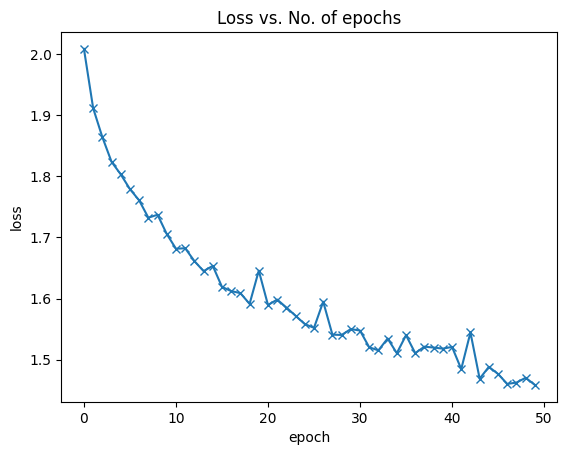

In [17]:
history =  history
plt.plot([x['loss'] for x in history], '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

**Model 2**

In [11]:
import torch.nn as nn
import torch.nn.functional as F


# its a 3 layer FFNn (one hidden layer)
class Feedforwardnn(nn.Module):
  def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
    super().__init__()
    self.hidden_layer1 = nn.Linear(input_size, hidden_size1)
    self.hidden_layer2 = nn.Linear(hidden_size1, hidden_size2)
    self.output_layer = nn.Linear(hidden_size2, output_size)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)# (128, 3, 32,32)--> (128,32*32*3)
    out = self.hidden_layer1(xb)
    out = F.relu(out)
    out = self.hidden_layer2(out)
    out = F.relu(out)
    out = self.output_layer(out)
    return out

  def training_step(self, xb):
    images, labels = xb
    # now we will pass the images to the NN
    out = self.forward(images)
    # now we will calculate the loss
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self, xb):
    images, labels = xb
    #passing the values
    out = self.forward(images)
    # calculating the loss
    loss = F.cross_entropy(out, labels)
    # calculating the accuracy
    _, pred = torch.max(out, dim =1)
    acc = torch.tensor(torch.sum(pred == labels).item()/ len(pred))
    return {'loss': loss.detach(), 'acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch}], loss: {result['loss']:.4f}, acc: {result['acc']:.4f}")




# hyper parameters
input_size = 32*32*3
hidden_size1 = 512
hidden_size2 = 128
output_size = 10
#The model will accept a batch of CIFAR-10 images,
#flatten each image to a 3072-dimensional vector, and process it
#through the layers of the neural network.
model = Feedforwardnn(input_size, hidden_size1, hidden_size2, output_size)


def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr,model, train_Loader, val_Loader, optimizer = torch.optim.SGD):
  history = []
  optimizer = optimizer(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_Loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(model, val_Loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [12]:
history = fit(50, 0.01, model, train_Loader, val_Loader)

Epoch [0], loss: 2.1691, acc: 0.2333
Epoch [1], loss: 2.0115, acc: 0.2872
Epoch [2], loss: 1.9362, acc: 0.3035
Epoch [3], loss: 1.8859, acc: 0.3291
Epoch [4], loss: 1.8460, acc: 0.3369
Epoch [5], loss: 1.8244, acc: 0.3471
Epoch [6], loss: 1.8022, acc: 0.3562
Epoch [7], loss: 1.7877, acc: 0.3665
Epoch [8], loss: 1.7424, acc: 0.3846
Epoch [9], loss: 1.7253, acc: 0.3825
Epoch [10], loss: 1.7163, acc: 0.3837
Epoch [11], loss: 1.6855, acc: 0.4013
Epoch [12], loss: 1.6712, acc: 0.4048
Epoch [13], loss: 1.6814, acc: 0.4035
Epoch [14], loss: 1.6617, acc: 0.4025
Epoch [15], loss: 1.6255, acc: 0.4207
Epoch [16], loss: 1.6047, acc: 0.4312
Epoch [17], loss: 1.6135, acc: 0.4270
Epoch [18], loss: 1.6151, acc: 0.4265
Epoch [19], loss: 1.6145, acc: 0.4321
Epoch [20], loss: 1.5800, acc: 0.4440
Epoch [21], loss: 1.5484, acc: 0.4582
Epoch [22], loss: 1.5559, acc: 0.4536
Epoch [23], loss: 1.5704, acc: 0.4419
Epoch [24], loss: 1.5316, acc: 0.4684
Epoch [25], loss: 1.5093, acc: 0.4695
Epoch [26], loss: 1.52